In [2]:
# Import libraries
import numpy as np              # For math operations
import pandas as pd             # For data tables
import matplotlib.pyplot as plt # For charts
import seaborn as sns          # For beautiful charts
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')  # Hide warning messages

# Set random seed for reproducibility
# This means you'll get the same results every time
np.random.seed(42)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
def generate_sample_transactions(n_samples=1000, fraud_ratio=0.02):
    """
    Create fake transaction data for learning

    Parameters:
    - n_samples: How many transactions to create
    - fraud_ratio: What percentage should be fraudulent (2% is realistic)
    """

    print(f"🏭 Generating {n_samples} sample transactions...")
    print(f"   (Including {int(n_samples * fraud_ratio)} fraudulent ones)\n")

    # Calculate how many of each type
    n_fraud = int(n_samples * fraud_ratio)
    n_normal = n_samples - n_fraud

    # Create NORMAL transactions (legitimate purchases)
    normal_data = {
        'user_id': np.random.randint(1, 100, n_normal),
        'amount': np.random.lognormal(4, 1, n_normal).clip(10, 1000),  # $10-$1000
        'timestamp': [datetime.now() - timedelta(hours=np.random.randint(0, 720))
                      for _ in range(n_normal)],
        'is_international': np.random.choice([0, 1], n_normal, p=[0.9, 0.1]),  # 10% international
        'merchant_risk_score': np.random.uniform(0, 30, n_normal),  # Low risk merchants
        'is_fraud_label': [0] * n_normal  # Label: 0 = NOT fraud
    }

    # Create FRAUDULENT transactions (unusual patterns)
    fraud_data = {
        'user_id': np.random.randint(1, 100, n_fraud),
        'amount': np.random.uniform(2000, 10000, n_fraud),  # Very high amounts!
        'timestamp': [datetime.now() - timedelta(hours=np.random.randint(0, 720))
                      for _ in range(n_fraud)],
        'is_international': np.random.choice([0, 1], n_fraud, p=[0.3, 0.7]),  # 70% international!
        'merchant_risk_score': np.random.uniform(60, 100, n_fraud),  # High risk merchants!
        'is_fraud_label': [1] * n_fraud  # Label: 1 = FRAUD
    }

    # Combine both types
    df_normal = pd.DataFrame(normal_data)
    df_fraud = pd.DataFrame(fraud_data)
    df = pd.concat([df_normal, df_fraud], ignore_index=True)

    # Shuffle so fraud is mixed in
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    print("✅ Data generated!")
    return df

# Generate data
transactions = generate_sample_transactions(n_samples=2000)

# Show first few transactions
print("\n📊 First 5 transactions:")
print(transactions.head())

print(f"\n📈 Dataset Summary:")
print(f"   Total transactions: {len(transactions)}")
print(f"   Fraudulent: {transactions['is_fraud_label'].sum()}")
print(f"   Legitimate: {len(transactions) - transactions['is_fraud_label'].sum()}")

🏭 Generating 2000 sample transactions...
   (Including 40 fraudulent ones)

✅ Data generated!

📊 First 5 transactions:
   user_id      amount                  timestamp  is_international  \
0        6   32.062520 2025-11-25 20:15:59.818740                 1   
1       97   15.142440 2025-11-25 21:15:59.810024                 0   
2       63  137.573982 2025-12-08 22:15:59.815666                 0   
3       67   46.462976 2025-12-04 00:15:59.812813                 0   
4       22   83.317205 2025-12-08 01:15:59.815449                 0   

   merchant_risk_score  is_fraud_label  
0             8.236338               0  
1            19.342702               0  
2             0.345780               0  
3             8.194789               0  
4            12.703164               0  

📈 Dataset Summary:
   Total transactions: 2000
   Fraudulent: 40
   Legitimate: 1960


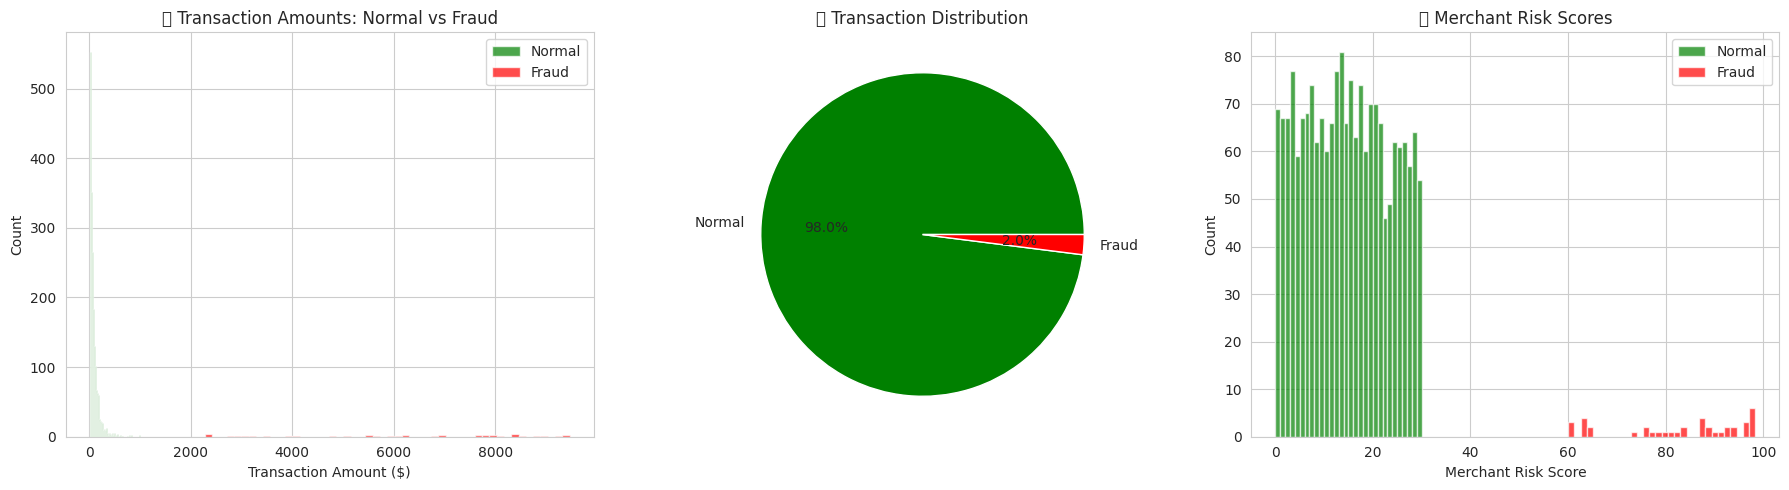


💡 What we can see:
   ✓ Fraudulent transactions have MUCH higher amounts
   ✓ Fraudulent transactions use riskier merchants
   ✓ Most transactions are normal (good!)


In [4]:
# Create visualizations
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Amount distribution
axes[0].hist(transactions[transactions['is_fraud_label']==0]['amount'],
             bins=50, alpha=0.7, label='Normal', color='green')
axes[0].hist(transactions[transactions['is_fraud_label']==1]['amount'],
             bins=50, alpha=0.7, label='Fraud', color='red')
axes[0].set_xlabel('Transaction Amount ($)')
axes[0].set_ylabel('Count')
axes[0].set_title('💰 Transaction Amounts: Normal vs Fraud')
axes[0].legend()

# 2. Fraud vs Normal pie chart
fraud_counts = transactions['is_fraud_label'].value_counts()
axes[1].pie(fraud_counts.values, labels=['Normal', 'Fraud'],
            autopct='%1.1f%%', colors=['green', 'red'])
axes[1].set_title('🥧 Transaction Distribution')

# 3. Risk scores
axes[2].hist(transactions[transactions['is_fraud_label']==0]['merchant_risk_score'],
             bins=30, alpha=0.7, label='Normal', color='green')
axes[2].hist(transactions[transactions['is_fraud_label']==1]['merchant_risk_score'],
             bins=30, alpha=0.7, label='Fraud', color='red')
axes[2].set_xlabel('Merchant Risk Score')
axes[2].set_ylabel('Count')
axes[2].set_title('🏪 Merchant Risk Scores')
axes[2].legend()

plt.tight_layout()
plt.show()

print("\n💡 What we can see:")
print("   ✓ Fraudulent transactions have MUCH higher amounts")
print("   ✓ Fraudulent transactions use riskier merchants")
print("   ✓ Most transactions are normal (good!)")

In [5]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

print("🔨 Building Fraud Detection System...\n")

# STEP 1: Feature Engineering
# We need to convert transactions into numbers the AI can understand

def extract_features(df):
    """
    Convert raw transaction data into features (numbers) for AI
    """
    print("⚙️ STEP 1: Extracting features from transactions...")

    features = pd.DataFrame()

    # Feature 1: Transaction amount
    features['amount'] = df['amount']

    # Feature 2: Hour of day (0-23)
    features['hour_of_day'] = pd.to_datetime(df['timestamp']).dt.hour

    # Feature 3: Day of week (0-6)
    features['day_of_week'] = pd.to_datetime(df['timestamp']).dt.dayofweek

    # Feature 4: Is international?
    features['is_international'] = df['is_international']

    # Feature 5: Merchant risk score
    features['merchant_risk_score'] = df['merchant_risk_score']

    # Feature 6: Time since last transaction (for same user)
    features['time_since_last'] = df.groupby('user_id')['timestamp'].diff().dt.total_seconds().fillna(3600)

    # Feature 7: Transaction velocity (how many in last 10)
    features['velocity'] = df.groupby('user_id')['amount'].transform(
        lambda x: x.rolling(window=10, min_periods=1).count()
    )

    # Feature 8: Deviation from user's average
    user_avg = df.groupby('user_id')['amount'].transform('mean')
    features['amount_deviation'] = abs(df['amount'] - user_avg) / (user_avg + 1)

    print(f"   ✓ Created {len(features.columns)} features")
    print(f"   Features: {list(features.columns)}\n")

    return features

# Extract features
features = extract_features(transactions)

print("📊 Sample features:")
print(features.head())

🔨 Building Fraud Detection System...

⚙️ STEP 1: Extracting features from transactions...
   ✓ Created 8 features
   Features: ['amount', 'hour_of_day', 'day_of_week', 'is_international', 'merchant_risk_score', 'time_since_last', 'velocity', 'amount_deviation']

📊 Sample features:
       amount  hour_of_day  day_of_week  is_international  \
0   32.062520           20            1                 1   
1   15.142440           21            1                 0   
2  137.573982           22            0                 0   
3   46.462976            0            3                 0   
4   83.317205            1            0                 0   

   merchant_risk_score  time_since_last  velocity  amount_deviation  
0             8.236338           3600.0       1.0          0.435783  
1            19.342702           3600.0       1.0          0.740243  
2             0.345780           3600.0       1.0          0.712519  
3             8.194789           3600.0       1.0          0.385274  
4

In [6]:
# STEP 2: Split data into training and testing

print("📂 STEP 2: Splitting data...\n")

# Use first 80% for training, last 20% for testing
split_point = int(len(transactions) * 0.8)

train_features = features[:split_point]
test_features = features[split_point:]
test_labels = transactions['is_fraud_label'][split_point:]

print(f"   Training set: {len(train_features)} transactions")
print(f"   Testing set:  {len(test_features)} transactions")
print(f"\n   💡 We train on 80% and test on unseen 20%\n")

📂 STEP 2: Splitting data...

   Training set: 1600 transactions
   Testing set:  400 transactions

   💡 We train on 80% and test on unseen 20%



In [7]:
# STEP 3: Normalize the features
# Why? So all features are on the same scale (0-1)

print("📏 STEP 3: Normalizing features...\n")

scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

print("   ✓ Features normalized (all values now between -3 and 3)\n")

📏 STEP 3: Normalizing features...

   ✓ Features normalized (all values now between -3 and 3)



In [8]:
# STEP 4: Train the AI model!

print("🎓 STEP 4: Training the Fraud Detection AI...\n")

# Create the model
model = IsolationForest(
    contamination=0.02,  # We expect 2% fraud
    random_state=42,
    n_estimators=100  # Use 100 trees in the forest
)

print("   🌲 Creating forest of 100 decision trees...")

# Train the model
model.fit(train_features_scaled)

print("   ✅ Training complete!")
print("\n   💡 The AI has learned what normal transactions look like!\n")

🎓 STEP 4: Training the Fraud Detection AI...

   🌲 Creating forest of 100 decision trees...
   ✅ Training complete!

   💡 The AI has learned what normal transactions look like!



🧪 STEP 5: Testing the model on unseen transactions...

   ✓ Predictions generated!

📊 MODEL PERFORMANCE:
   Accuracy:  100.0%  (How often we're correct)
   Precision: 100.0%  (When we say fraud, how often it's true)
   Recall:    100.0%  (How many frauds we catch)


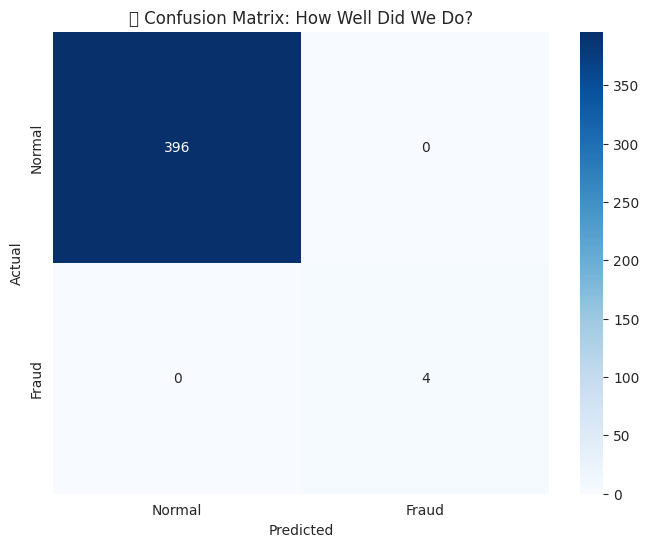


💡 Interpreting the matrix:
   ✅ True Negatives (Normal correctly identified): 396
   ✅ True Positives (Fraud correctly caught): 4
   ⚠️  False Positives (Normal flagged as fraud): 0
   ❌ False Negatives (Fraud we missed): 0


In [9]:
# STEP 5: Test the model on new data

print("🧪 STEP 5: Testing the model on unseen transactions...\n")

# Predict: -1 = fraud, 1 = normal
predictions = model.predict(test_features_scaled)

# Get risk scores (lower = more suspicious)
scores = model.score_samples(test_features_scaled)

# Convert to 0-100 risk scale (higher = more risky)
risk_scores = 100 * (1 - (scores - scores.min()) / (scores.max() - scores.min()))

# Convert predictions to binary (0 = normal, 1 = fraud)
predicted_fraud = (predictions == -1).astype(int)

print("   ✓ Predictions generated!\n")

# Calculate accuracy
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

accuracy = accuracy_score(test_labels, predicted_fraud)
precision = precision_score(test_labels, predicted_fraud)
recall = recall_score(test_labels, predicted_fraud)

print("📊 MODEL PERFORMANCE:")
print("="*50)
print(f"   Accuracy:  {accuracy*100:.1f}%  (How often we're correct)")
print(f"   Precision: {precision*100:.1f}%  (When we say fraud, how often it's true)")
print(f"   Recall:    {recall*100:.1f}%  (How many frauds we catch)")
print("="*50)

# Show confusion matrix
cm = confusion_matrix(test_labels, predicted_fraud)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Fraud'],
            yticklabels=['Normal', 'Fraud'])
plt.title('🎯 Confusion Matrix: How Well Did We Do?')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print("\n💡 Interpreting the matrix:")
print(f"   ✅ True Negatives (Normal correctly identified): {cm[0,0]}")
print(f"   ✅ True Positives (Fraud correctly caught): {cm[1,1]}")
print(f"   ⚠️  False Positives (Normal flagged as fraud): {cm[0,1]}")
print(f"   ❌ False Negatives (Fraud we missed): {cm[1,0]}")

In [10]:
# Let's test on a single transaction

print("\n🔍 TESTING ON A SINGLE TRANSACTION\n")
print("="*60)

# Pick a high-risk transaction
sample_idx = np.argmax(risk_scores)
sample_transaction = test_features.iloc[sample_idx]
sample_risk = risk_scores[sample_idx]
actual_fraud = test_labels.iloc[sample_idx]

print("Transaction Details:")
print(f"   Amount: ${transactions.iloc[split_point + sample_idx]['amount']:.2f}")
print(f"   Hour: {int(sample_transaction['hour_of_day'])}:00")
print(f"   International: {'Yes' if sample_transaction['is_international'] else 'No'}")
print(f"   Merchant Risk: {sample_transaction['merchant_risk_score']:.1f}/100")
print(f"\n🎯 AI PREDICTION:")
print(f"   Risk Score: {sample_risk:.1f}/100")
print(f"   Decision: {'🚫 BLOCK (Fraud Suspected)' if predicted_fraud[sample_idx] else '✅ APPROVE'}")
print(f"   Actual: {'🚫 WAS FRAUD' if actual_fraud else '✅ WAS NORMAL'}")
print(f"   Result: {'✅ CORRECT!' if predicted_fraud[sample_idx] == actual_fraud else '❌ WRONG'}")
print("="*60)


🔍 TESTING ON A SINGLE TRANSACTION

Transaction Details:
   Amount: $8514.41
   Hour: 5:00
   International: Yes
   Merchant Risk: 79.1/100

🎯 AI PREDICTION:
   Risk Score: 100.0/100
   Decision: 🚫 BLOCK (Fraud Suspected)
   Actual: 🚫 WAS FRAUD
   Result: ✅ CORRECT!


In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("🛡️ Building Adversarial Defense System...\n")

# STEP 1: Build the Autoencoder

print("🏗️ STEP 1: Creating Autoencoder Architecture...\n")

input_dim = train_features_scaled.shape[1]  # Number of features

# Create the model
encoder_input = keras.Input(shape=(input_dim,))

# Encoder (compress the data)
encoded = layers.Dense(16, activation='relu')(encoder_input)
encoded = layers.Dense(8, activation='relu')(encoded)
encoded = layers.Dense(4, activation='relu')(encoded)  # Compressed to 4 numbers!

# Decoder (reconstruct the data)
decoded = layers.Dense(8, activation='relu')(encoded)
decoded = layers.Dense(16, activation='relu')(decoded)
decoder_output = layers.Dense(input_dim, activation='linear')(decoded)  # Back to original size

# Complete autoencoder
autoencoder = keras.Model(encoder_input, decoder_output)

# Compile the model
autoencoder.compile(
    optimizer='adam',
    loss='mse',  # Mean Squared Error
    metrics=['mae']  # Mean Absolute Error
)

print("   ✓ Autoencoder created!")
print(f"\n   Architecture: {input_dim} → 16 → 8 → 4 → 8 → 16 → {input_dim}")
print("   💡 Data gets compressed to just 4 numbers, then reconstructed!\n")

# Show model summary
autoencoder.summary()

🛡️ Building Adversarial Defense System...

🏗️ STEP 1: Creating Autoencoder Architecture...

   ✓ Autoencoder created!

   Architecture: 8 → 16 → 8 → 4 → 8 → 16 → 8
   💡 Data gets compressed to just 4 numbers, then reconstructed!



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 636 (2.48 KB)

 Trainable params: 636 (2.48 KB)

 Non-trainable params: 0 (0.00 B)


🎓 STEP 2: Training the Autoencoder...

   This will take 30-60 seconds...

   ✅ Training complete!



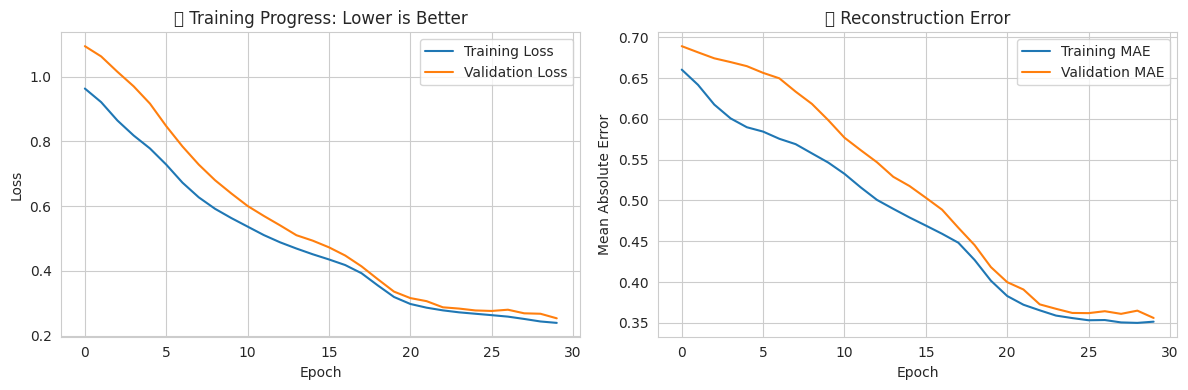


💡 The model learned to perfectly reconstruct normal transactions!


In [12]:
# STEP 2: Train the Autoencoder

print("\n🎓 STEP 2: Training the Autoencoder...\n")
print("   This will take 30-60 seconds...\n")

# Train on NORMAL transactions only
history = autoencoder.fit(
    train_features_scaled,
    train_features_scaled,  # Try to recreate the input!
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    verbose=0  # Silent training
)

print("   ✅ Training complete!\n")

# Plot training progress
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('📉 Training Progress: Lower is Better')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.title('📊 Reconstruction Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("\n💡 The model learned to perfectly reconstruct normal transactions!")

🎯 STEP 3: Setting Detection Threshold...

   Detection Threshold: 0.732517
   💡 Anything above this is suspicious!



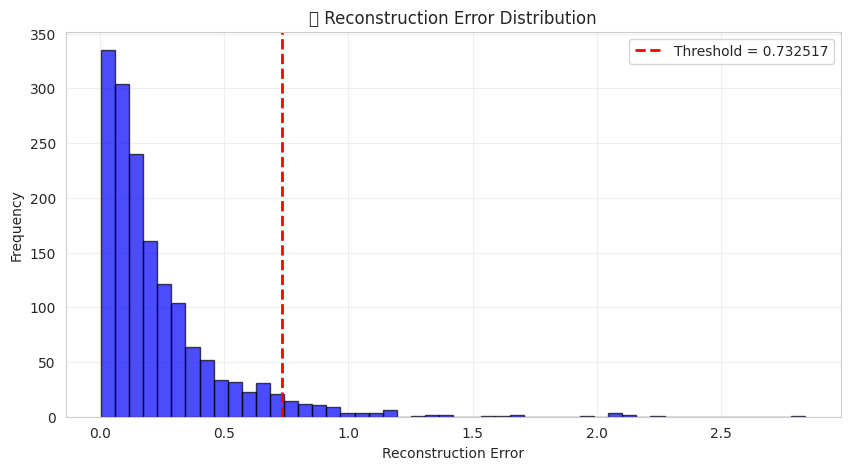

💡 Normal transactions have LOW reconstruction error
💡 Adversarial attacks have HIGH reconstruction error


In [13]:
# STEP 3: Calculate Detection Threshold

print("🎯 STEP 3: Setting Detection Threshold...\n")

# Reconstruct training data
reconstructions = autoencoder.predict(train_features_scaled, verbose=0)

# Calculate reconstruction errors
reconstruction_errors = np.mean(np.square(train_features_scaled - reconstructions), axis=1)

# Set threshold at 95th percentile
threshold = np.percentile(reconstruction_errors, 95)

print(f"   Detection Threshold: {threshold:.6f}")
print("   💡 Anything above this is suspicious!\n")

# Visualize threshold
plt.figure(figsize=(10, 5))
plt.hist(reconstruction_errors, bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold = {threshold:.6f}')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('📊 Reconstruction Error Distribution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("💡 Normal transactions have LOW reconstruction error")
print("💡 Adversarial attacks have HIGH reconstruction error")

In [14]:
# STEP 4: Create an Adversarial Attack (for demonstration)

print("\n⚔️ STEP 4: Creating an Adversarial Attack...\n")
print("   (Don't worry, this is just for learning!)\n")

# Pick a normal transaction
sample_transaction = test_features_scaled[0:1]

# Create adversarial version by adding noise
noise = np.random.normal(0, 0.5, sample_transaction.shape)
adversarial_transaction = sample_transaction + noise

# Test both
normal_reconstruction = autoencoder.predict(sample_transaction, verbose=0)
adv_reconstruction = autoencoder.predict(adversarial_transaction, verbose=0)

normal_error = np.mean(np.square(sample_transaction - normal_reconstruction))
adv_error = np.mean(np.square(adversarial_transaction - adv_reconstruction))

print("Results:")
print("="*60)
print(f"   Normal Transaction Error:      {normal_error:.6f}")
print(f"   Adversarial Transaction Error: {adv_error:.6f}")
print(f"   Detection Threshold:           {threshold:.6f}")
print("="*60)

print(f"\n   Normal: {'✅ ACCEPTED' if normal_error < threshold else '🚫 REJECTED'}")
print(f"   Adversarial: {'✅ ACCEPTED (Attack Successful!)' if adv_error < threshold else '🚫 REJECTED (Attack Blocked!)'}")

if adv_error > threshold:
    print("\n   🎉 Our defense system caught the attack!")
else:
    print("\n   ⚠️ Attack got through (try increasing noise)")


⚔️ STEP 4: Creating an Adversarial Attack...

   (Don't worry, this is just for learning!)

Results:
   Normal Transaction Error:      0.105635
   Adversarial Transaction Error: 0.471551
   Detection Threshold:           0.732517

   Normal: ✅ ACCEPTED
   Adversarial: ✅ ACCEPTED (Attack Successful!)

   ⚠️ Attack got through (try increasing noise)


In [15]:
print("🔐 Building Privacy-Preserving System...\n")

class DifferentialPrivacy:
    """
    Simple differential privacy implementation
    """

    def __init__(self, epsilon=1.0):
        """
        epsilon: Privacy budget
        - Lower epsilon = more privacy, less accuracy
        - Higher epsilon = less privacy, more accuracy
        - Typical: epsilon = 0.1 to 2.0
        """
        self.epsilon = epsilon
        print(f"   Created DP engine with epsilon = {epsilon}")
        print(f"   💡 Privacy level: {'🔒 HIGH' if epsilon < 0.5 else '🔓 MEDIUM' if epsilon < 1.5 else '⚠️ LOW'}\n")

    def add_laplace_noise(self, value, sensitivity):
        """
        Add Laplace noise to a value
        """
        scale = sensitivity / self.epsilon
        noise = np.random.laplace(0, scale)
        return value + noise

    def private_mean(self, data, min_val, max_val):
        """
        Calculate private mean
        """
        # Clip data to range
        clipped_data = np.clip(data, min_val, max_val)

        # Calculate true mean
        true_mean = np.mean(clipped_data)

        # Add noise (sensitivity = range / n)
        sensitivity = (max_val - min_val) / len(data)
        noisy_mean = self.add_laplace_noise(true_mean, sensitivity)

        return noisy_mean

# Test differential privacy
print("\n🧪 Testing Differential Privacy:\n")
print("="*60)

# Get transaction amounts
amounts = transactions['amount'].values

# Calculate true mean
true_mean = np.mean(amounts)

# Calculate private means with different epsilon values
epsilons = [0.1, 0.5, 1.0, 5.0]
results = []

for eps in epsilons:
    dp = DifferentialPrivacy(epsilon=eps)
    private_mean = dp.private_mean(amounts, 0, 10000)
    error = abs(true_mean - private_mean)
    results.append((eps, private_mean, error))

print(f"\nTrue Mean: ${true_mean:.2f}\n")
print("Privacy Budget (ε) | Private Mean | Error")
print("-" * 50)
for eps, pm, err in results:
    privacy_level = "🔒 High" if eps < 0.5 else "🔓 Medium" if eps < 2.0 else "⚠️ Low"
    print(f"ε = {eps:4.1f} ({privacy_level:12s}) | ${pm:8.2f} | ${err:6.2f}")

print("\n💡 Key Insight: Lower epsilon = more privacy but less accuracy!")

🔐 Building Privacy-Preserving System...


🧪 Testing Differential Privacy:

   Created DP engine with epsilon = 0.1
   💡 Privacy level: 🔒 HIGH

   Created DP engine with epsilon = 0.5
   💡 Privacy level: 🔓 MEDIUM

   Created DP engine with epsilon = 1.0
   💡 Privacy level: 🔓 MEDIUM

   Created DP engine with epsilon = 5.0
   💡 Privacy level: ⚠️ LOW


True Mean: $209.32

Privacy Budget (ε) | Private Mean | Error
--------------------------------------------------
ε =  0.1 (🔒 High      ) | $  240.96 | $ 31.65
ε =  0.5 (🔓 Medium    ) | $  206.23 | $  3.09
ε =  1.0 (🔓 Medium    ) | $  192.93 | $ 16.38
ε =  5.0 (⚠️ Low      ) | $  207.71 | $  1.60

💡 Key Insight: Lower epsilon = more privacy but less accuracy!


In [16]:
print("🔧 Creating Complete Security Pipeline...\n")

def process_transaction_secure(transaction_data, verbose=True):
    """
    Process a transaction through complete security pipeline
    """
    if verbose:
        print("\n" + "="*60)
        print("  🔐 PROCESSING TRANSACTION")
        print("="*60)

    # STEP 1: Input Validation
    if verbose:
        print("\n[1/4] 📋 Input Validation")

    amount = transaction_data['amount']
    if amount < 0 or amount > 100000:
        if verbose:
            print("      ❌ Invalid amount detected!")
        return {"decision": "REJECTED", "reason": "Invalid input"}

    if verbose:
        print("      ✅ Input validation passed")

    # STEP 2: Fraud Detection
    if verbose:
        print("\n[2/4] 🔍 AI Fraud Detection")

    # Extract and scale features
    features_df = extract_features(pd.DataFrame([transaction_data]))
    features_scaled = scaler.transform(features_df)

    # Predict
    prediction = model.predict(features_scaled)[0]
    score = model.score_samples(features_scaled)[0]
    risk_score = 100 * (1 - (score - scores.min()) / (scores.max() - scores.min()))

    if verbose:
        print(f"      Risk Score: {risk_score:.1f}/100")

    if prediction == -1:  # Fraud detected
        if verbose:
            print("      🚫 FRAUD DETECTED!")
        return {"decision": "BLOCKED", "reason": "Fraud detected", "risk_score": risk_score}

    if verbose:
        print("      ✅ Appears legitimate")

    # STEP 3: Adversarial Defense
    if verbose:
        print("\n[3/4] 🛡️ Adversarial Attack Check")

    reconstruction = autoencoder.predict(features_scaled, verbose=0)
    recon_error = np.mean(np.square(features_scaled - reconstruction))

    if verbose:
        print(f"      Reconstruction Error: {recon_error:.6f}")
        print(f"      Threshold: {threshold:.6f}")

    if recon_error > threshold:
        if verbose:
            print("      ⚠️ ADVERSARIAL ATTACK DETECTED!")
        return {"decision": "BLOCKED", "reason": "Adversarial attack", "risk_score": 99.0}

    if verbose:
        print("      ✅ Clean input verified")

    # STEP 4: Privacy-Preserving Logging
    if verbose:
        print("\n[4/4] 🔒 Privacy-Preserving Logging")

    # Hash user ID for privacy
    import hashlib
    user_hash = hashlib.sha256(str(transaction_data['user_id']).encode()).hexdigest()[:16]

    if verbose:
        print(f"      User ID anonymized: {user_hash}...")
        print("\n" + "="*60)
        print("  ✅ TRANSACTION APPROVED")
        print("="*60)

    return {
        "decision": "APPROVED",
        "risk_score": risk_score,
        "anonymized_user": user_hash
    }

print("✅ Security pipeline ready!\n")

🔧 Creating Complete Security Pipeline...

✅ Security pipeline ready!



In [17]:
# Test the complete pipeline

print("\n🧪 TESTING COMPLETE SECURITY PIPELINE\n")

# Test 1: Normal transaction
print("\n" + "#"*60)
print("# TEST 1: Normal Transaction")
print("#"*60)

normal_trans = {
    'user_id': 42,
    'amount': 150.00,
    'timestamp': datetime.now(),
    'is_international': 0,
    'merchant_risk_score': 15.0
}

result1 = process_transaction_secure(normal_trans, verbose=True)

# Test 2: Suspicious transaction
print("\n\n" + "#"*60)
print("# TEST 2: Suspicious Transaction (High Amount)")
print("#"*60)

suspicious_trans = {
    'user_id': 99,
    'amount': 8500.00,
    'timestamp': datetime.now(),
    'is_international': 1,
    'merchant_risk_score': 85.0
}

result2 = process_transaction_secure(suspicious_trans, verbose=True)

print("\n\n" + "="*60)
print("  🎉 PIPELINE TESTING COMPLETE!")
print("="*60)


🧪 TESTING COMPLETE SECURITY PIPELINE


############################################################
# TEST 1: Normal Transaction
############################################################

  🔐 PROCESSING TRANSACTION

[1/4] 📋 Input Validation
      ✅ Input validation passed

[2/4] 🔍 AI Fraud Detection
⚙️ STEP 1: Extracting features from transactions...
   ✓ Created 8 features
   Features: ['amount', 'hour_of_day', 'day_of_week', 'is_international', 'merchant_risk_score', 'time_since_last', 'velocity', 'amount_deviation']

      Risk Score: 30.6/100
      ✅ Appears legitimate

[3/4] 🛡️ Adversarial Attack Check
      Reconstruction Error: 0.033102
      Threshold: 0.732517
      ✅ Clean input verified

[4/4] 🔒 Privacy-Preserving Logging
      User ID anonymized: 73475cb40a568e8d...

  ✅ TRANSACTION APPROVED


############################################################
# TEST 2: Suspicious Transaction (High Amount)
############################################################

  🔐 PROCE

In [18]:
# Process all test transactions and create summary

print("\n📊 Processing all test transactions...\n")

test_transactions = transactions[split_point:].reset_index(drop=True)
results = []

for idx, row in test_transactions.iterrows():
    result = process_transaction_secure(row.to_dict(), verbose=False)
    results.append(result)
    if (idx + 1) % 50 == 0:
        print(f"   Processed {idx + 1}/{len(test_transactions)} transactions...")

print("\n✅ All transactions processed!\n")

# Calculate metrics
approved = sum(1 for r in results if r['decision'] == 'APPROVED')
blocked_fraud = sum(1 for r in results if r.get('reason') == 'Fraud detected')
blocked_adversarial = sum(1 for r in results if r.get('reason') == 'Adversarial attack')
blocked_invalid = sum(1 for r in results if r.get('reason') == 'Invalid input')

print("\n" + "="*60)
print("  📈 FINAL SECURITY REPORT")
print("="*60)
print(f"\n  Total Transactions: {len(results)}")
print(f"  ✅ Approved: {approved} ({approved/len(results)*100:.1f}%)")
print(f"  🚫 Blocked (Fraud): {blocked_fraud} ({blocked_fraud/len(results)*100:.1f}%)")
print(f"  🛡️ Blocked (Adversarial): {blocked_adversarial} ({blocked_adversarial/len(results)*100:.1f}%)")
print(f"  ❌ Blocked (Invalid): {blocked_invalid} ({blocked_invalid/len(results)*100:.1f}%)")
print("\n" + "="*60)

# Accuracy check
correct = sum(1 for i, r in enumerate(results)
              if (r['decision'] == 'APPROVED' and test_labels.iloc[i] == 0) or
                 (r['decision'] == 'BLOCKED' and test_labels.iloc[i] == 1))

accuracy = correct / len(results) * 100
print(f"\n  🎯 Overall Accuracy: {accuracy:.1f}%")
print("\n" + "="*60)


📊 Processing all test transactions...

⚙️ STEP 1: Extracting features from transactions...
   ✓ Created 8 features
   Features: ['amount', 'hour_of_day', 'day_of_week', 'is_international', 'merchant_risk_score', 'time_since_last', 'velocity', 'amount_deviation']

⚙️ STEP 1: Extracting features from transactions...
   ✓ Created 8 features
   Features: ['amount', 'hour_of_day', 'day_of_week', 'is_international', 'merchant_risk_score', 'time_since_last', 'velocity', 'amount_deviation']

⚙️ STEP 1: Extracting features from transactions...
   ✓ Created 8 features
   Features: ['amount', 'hour_of_day', 'day_of_week', 'is_international', 'merchant_risk_score', 'time_since_last', 'velocity', 'amount_deviation']

⚙️ STEP 1: Extracting features from transactions...
   ✓ Created 8 features
   Features: ['amount', 'hour_of_day', 'day_of_week', 'is_international', 'merchant_risk_score', 'time_since_last', 'velocity', 'amount_deviation']

⚙️ STEP 1: Extracting features from transactions...
   ✓ Cre


📊 Creating final visualizations...



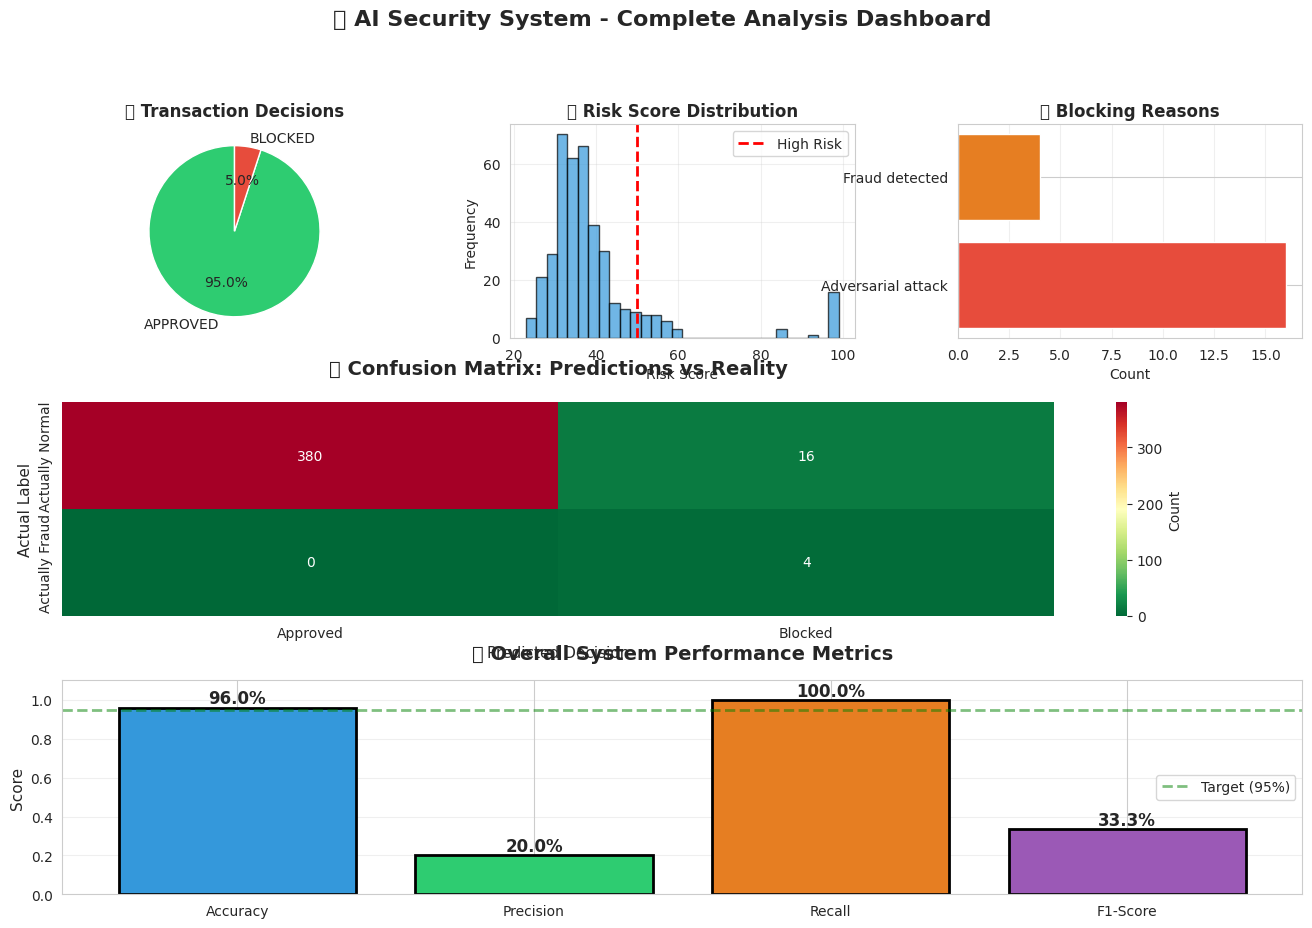

✅ Visualizations complete!


In [19]:
# Create final visualization

print("\n📊 Creating final visualizations...\n")

fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Decision pie chart
ax1 = fig.add_subplot(gs[0, 0])
decisions = pd.Series([r['decision'] for r in results]).value_counts()
colors = ['#2ecc71' if d == 'APPROVED' else '#e74c3c' for d in decisions.index]
ax1.pie(decisions.values, labels=decisions.index, autopct='%1.1f%%',
        colors=colors, startangle=90)
ax1.set_title('🎯 Transaction Decisions', fontsize=12, fontweight='bold')

# 2. Risk score distribution
ax2 = fig.add_subplot(gs[0, 1])
risk_scores_final = [r.get('risk_score', 0) for r in results]
ax2.hist(risk_scores_final, bins=30, color='#3498db', edgecolor='black', alpha=0.7)
ax2.axvline(50, color='red', linestyle='--', linewidth=2, label='High Risk')
ax2.set_xlabel('Risk Score')
ax2.set_ylabel('Frequency')
ax2.set_title('📊 Risk Score Distribution', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Block reasons
ax3 = fig.add_subplot(gs[0, 2])
blocked = [r for r in results if r['decision'] == 'BLOCKED']
if blocked:
    reasons = pd.Series([r.get('reason', 'Unknown') for r in blocked]).value_counts()
    ax3.barh(reasons.index, reasons.values, color=['#e74c3c', '#e67e22', '#95a5a6'])
    ax3.set_xlabel('Count')
    ax3.set_title('🚫 Blocking Reasons', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='x')

# 4. Confusion matrix
ax4 = fig.add_subplot(gs[1, :])
predicted = [0 if r['decision'] == 'APPROVED' else 1 for r in results]
cm = confusion_matrix(test_labels, predicted)
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn_r', ax=ax4,
            xticklabels=['Approved', 'Blocked'],
            yticklabels=['Actually Normal', 'Actually Fraud'],
            cbar_kws={'label': 'Count'})
ax4.set_title('🎯 Confusion Matrix: Predictions vs Reality',
             fontsize=14, fontweight='bold', pad=20)
ax4.set_ylabel('Actual Label', fontsize=11)
ax4.set_xlabel('Predicted Decision', fontsize=11)

# 5. Performance metrics
ax5 = fig.add_subplot(gs[2, :])
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
precision_val = precision_score(test_labels, predicted)
recall_val = recall_score(test_labels, predicted)
f1_val = 2 * (precision_val * recall_val) / (precision_val + recall_val) if (precision_val + recall_val) > 0 else 0
metrics_values = [accuracy/100, precision_val, recall_val, f1_val]
colors_metrics = ['#3498db', '#2ecc71', '#e67e22', '#9b59b6']

bars = ax5.bar(metrics_names, metrics_values, color=colors_metrics, edgecolor='black', linewidth=2)
ax5.set_ylim([0, 1.1])
ax5.set_ylabel('Score', fontsize=11)
ax5.set_title('📈 Overall System Performance Metrics', fontsize=14, fontweight='bold', pad=15)
ax5.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, value in zip(bars, metrics_values):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:.1%}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

# Add horizontal line at 0.95
ax5.axhline(y=0.95, color='green', linestyle='--', linewidth=2, alpha=0.5, label='Target (95%)')
ax5.legend()

plt.suptitle('🔐 AI Security System - Complete Analysis Dashboard',
             fontsize=16, fontweight='bold', y=0.995)

plt.show()

print("✅ Visualizations complete!")